In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 509
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

2024-02-07 10:19:09.386897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 10:19:12.303854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-07 10:19:12.308687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-07 10:19:12.311038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

Running on GPU


In [2]:
### Sverdrup 
# mainDir_r4  = '/scratch2/pillarh/eccov4r4'
# mainDir_r5  = '/scratch2/pillarh/eccov4r5'
# gridDir  = mainDir_r4 + '/GRID'
# thetaDir = mainDir_r5 + '/V4r5/diags_daily/SST_day_mean'
# thetaDir_ext = mainDir_r5 + '/V4r5_ext_2020_2023_Jun/diags_daily/SST_day_mean'

## LS6
mainDir_r4 = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
mainDir_r5 = '/work/07665/shrey911/ls6/LRP_eccov4r5_data'
gridDir  = mainDir_r5 + '/GRID'
thetaDir = mainDir_r5 + '/SST_day_mean'
thetaDir_ext = mainDir_r5 + '/SST_day_mean_ext_2020_2023_Jun'

# For Sverdrup
# ds_r4 = xr.open_dataset(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')
# For LS6
ds_r4 = xr.open_dataset(mainDir_r4 + '/thetaSurfECCOv4r4.nc')

# SSH has to be kept because someone used the SSH metadata for SST, 
# It's not a bug in this code but a hack to handle an existing bug.
temp = xmitgcm.open_mdsdataset(data_dir = thetaDir,
                             grid_dir = gridDir,
                             extra_variables = dict(SSH = dict(dims=['k','j','i'],
                                                               attrs = dict(standard_name="SST",
                                                                            long_name="Sea Surface Temperature",
                                                                            units="degC"))))
temp["SST"] = temp["SSH"]
temp = temp.drop(["SSH"])
    
temp_ext = xmitgcm.open_mdsdataset(data_dir = thetaDir_ext,
                                 grid_dir = gridDir,
                                 extra_variables = dict(SST = dict(dims=['k','j','i'],
                                                                   attrs = dict(standard_name="SST",
                                                                                long_name="Sea Surface Temperature",
                                                                                units="degC"))))

ds_r5 = xr.concat([temp, temp_ext], "time")

In [3]:
ds_SST = xr.open_dataset(mainDir_r5+'/SST_all.nc')
SST = ds_SST['SST'].data

In [4]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds_r4['XC'].data
YC = ds_r4['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_XC = xr.DataArray(
    data=ds_r4['XC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="XC"),
)

da_YC = xr.DataArray(
    data=ds_r4['YC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="YC"),
)

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

wetpoints = np.nonzero(maskFinal.data)
da_wetpoints = xr.DataArray(
    data=np.asarray(wetpoints),
    dims=["wetpoints_dim", "num_wetpoints"],
    coords=dict(
        wetpoints_dim = np.arange(np.asarray(wetpoints).shape[0], dtype = int),
        num_wetpoints = np.arange(np.asarray(wetpoints).shape[1], dtype = int),
    ),
    attrs=dict(description="indices of wetpoints in the order (tile, j, i) in the three rows"),
)

da_SST = xr.DataArray(
    data=SST,
    dims=["time", "tile", "j", "i"],
    coords=dict(
        time = ds_r5['time'].data[:SST.shape[0]],
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="SST field in llc format"),
)

ds = xr.Dataset()
ds = ds.assign(XC           = da_XC,
               YC           = da_YC,
               hFacC_mask   = da_hFacC_mask,
               latMask      = da_latMask,
               maskFinal    = da_maskFinal,
               NaNmaskFinal = da_NaNmaskFinal,
               wetpoints    = da_wetpoints,
               SST          = da_SST)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r5_data/GRID/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [5]:
def anomalize(field):
    
    leap_yr_offsets_jan_feb   = [0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8]
    leap_yr_offsets_after_feb = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8]

    if len(field.shape) > 1:
        seasonal_trend = np.zeros((366, field.shape[1]))
    else:
        seasonal_trend = np.zeros((366,))

    #### Calculate seasonal trend
    
    # Jan 1 - Feb 28
    for d in range(59):
        for year in range(31):
            seasonal_trend[d] += field[d+365*year+leap_yr_offsets_jan_feb[year]]
    seasonal_trend[:59] = seasonal_trend[:59] / 31.0
    
    # Feb 29 starting 1996, so year 2 in 0-indefielding
    n = 0
    for year in range(0,31,4):
        seasonal_trend[59] += field[365*year+n+59]
        n = n+1
    seasonal_trend[59] = seasonal_trend[59] / 8.0
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        for year in range(31):
            seasonal_trend[d] += field[d-1+365*year+leap_yr_offsets_after_feb[year]]
    seasonal_trend[60:] = seasonal_trend[60:] / 31.0
    
    #### Deseason data
    
    # Jan 1 - Feb 28
    for d in range(59):
        for year in range(31):
            field[d+365*year+leap_yr_offsets_jan_feb[year]] = field[d+365*year+leap_yr_offsets_jan_feb[year]] \
                                                        - seasonal_trend[d]
    
    # Feb 29 starting 1996, so year 2 in 0-indexing
    n = 0
    for year in range(0,31,4):
        field[365*year+n+59] = field[365*year+n+59] - seasonal_trend[59]
        n = n+1
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        for year in range(31):
            field[d-1+365*year+leap_yr_offsets_after_feb[year]] = field[d-1+365*year+leap_yr_offsets_after_feb[year]] \
                                                            - seasonal_trend[d]

    scipy.signal.detrend(field, axis=0, type='linear', bp=0, overwrite_data=True)
    field = field - np.mean(field, axis = 0)

    return field

In [6]:
X = ds['SST'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
X = anomalize(X)
X_full = X.copy()
X = X[30:-30]

y = ds['SST'].isel(tile = 10, j = 1, i = 43).data.copy()
y = anomalize(y)
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

In [7]:
da_X = xr.DataArray(
    data=X,
    dims=["time_allData", "num_wetpoints"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data as matrix X; deseasoned, delinearized and mean removed."),
)

da_y = xr.DataArray(
    data=y,
    dims=["time_allData"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
    ),
    attrs=dict(description="All cost function y; deseasoned, delinearized and mean removed."),
)

da_X_full = xr.DataArray(
    data=X_full,
    dims=["time", "num_wetpoints"],
    coords=dict(
        time          = ds['time'],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data without accounting for conv filter as matrix X_full; deseasoned, delinearized and mean removed."),
)

da_oneHotCost = xr.DataArray(
    data=oneHotCost,
    dims=["time_allData", "NN_output_dim"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        NN_output_dim = np.array([0,1]),
    ),
    attrs=dict(description="All cost function as one-hot vector."),
)

ds = ds.assign(X          = da_X,
               y          = da_y,
               X_full     = da_X_full,
               oneHotCost = da_oneHotCost)

## Classification

In [8]:
def LRP(model, model_wo_softmax, X, y_true, lagSteps, lrp_methods, 
        suffix, normalizeDict, **kwargs):

    result = {}
    cost_NN = model.predict(X)
    result[f'score_{suffix}'] = model.evaluate(X, y_true, verbose=0)

    pred_NN = cost_NN.copy()
    pred_NN[:,0] = pred_NN[:,0] > 0.5
    pred_NN[:,1] = pred_NN[:,1] > 0.5

    idx_NN_pos = []
    idx_NN_neg = []

    if lagSteps >= 0:
        for i in range(len(y_true[lagSteps:,0])):
            if y_true[lagSteps+i,0] == 1 and pred_NN[i,0] == 1:
                idx_NN_pos.append(i)
            if y_true[lagSteps+i,1] == 1 and pred_NN[i,1] == 1:
                idx_NN_neg.append(i)
    else:
        for i in range(len(y_true[:lagSteps,0])):
            if y_true[i,0] == 1 and pred_NN[i-lagSteps,0] == 1:
                idx_NN_pos.append(i-lagSteps)
            if y_true[i,1] == 1 and pred_NN[i-lagSteps,1] == 1:
                idx_NN_neg.append(i-lagSteps)    

    rel = np.zeros((len(idx_NN_pos), 13, 90, 90))
    rel[:,:,:,:] = np.nan
    rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = X[idx_NN_pos]
    result[f'samples_correct_pos_{suffix}'] = rel

    rel = np.zeros((len(idx_NN_neg), 13, 90, 90))
    rel[:,:,:,:] = np.nan
    rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = X[idx_NN_neg]
    result[f'samples_correct_neg_{suffix}'] = rel
    
    for method in lrp_methods:

        title = method['title']
        
        print(f'Analyze using {title} for {suffix} data')
        
        Xplain = XAIR(model_wo_softmax, method, 'classic', X[idx_NN_pos], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        
        rel = np.zeros((a.shape[0], 13, 90, 90))
        rel[:,:,:,:] = np.nan
        rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = a
        result[method['title']+f'_pos_{suffix}'] = rel

        Xplain = XAIR(model_wo_softmax, method, 'classic', X[idx_NN_neg], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        
        rel = np.zeros((a.shape[0], 13, 90, 90))
        rel[:,:,:,:] = np.nan
        rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = a
        result[method['title']+f'_neg_{suffix}'] = rel

    return result

def quickSetup(X, y,
               test_split_frac,
               lrp_methods,
               lagSteps,
               decay_func = None,
               **NNkwargs):
    
    result = {}

    idx = int(X.shape[0]*(1-test_split_frac))
    X_train = X[:idx]
    oneHotCost_train = oneHotCost[:idx]
    X_test = X[idx:]
    oneHotCost_test = oneHotCost[idx:]

    keras.backend.clear_session()
    sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    NNkwargs['optimizer'] = sgd
    
    if lagSteps > 0:
        K = TrainFullyConnectedNN(X_train[:-lagSteps], oneHotCost_train[lagSteps:], **NNkwargs)
    elif lagSteps == 0:
        K = TrainFullyConnectedNN(X_train, oneHotCost_train, **NNkwargs)
    else:
        K = TrainFullyConnectedNN(X_train[-lagSteps:], oneHotCost_train[:lagSteps], **NNkwargs)
        
    best_model = K.quickTrain(decay_func)
    best_model_wo_softmax = innvestigate.model_wo_softmax(best_model)
                   
    result['cost_predict_NN'] = best_model.predict(X)
                   
    normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
    kwargs = {'y_ref': 0.00}

    # LRP for all data
    result_train = LRP(best_model, best_model_wo_softmax, 
                       X, oneHotCost, lagSteps, lrp_methods, 
                       suffix = 'all', normalizeDict = normalizeDict, **kwargs)
    result.update(result_train)
    
    # # LRP for training data
    # result_train = LRP(best_model, best_model_wo_softmax, 
    #                    X_train, oneHotCost_train, lagSteps, lrp_methods, 
    #                    suffix = 'train', normalizeDict = normalizeDict, **kwargs)
    # result.update(result_train)

    # # LRP for test data
    # result_test = LRP(best_model, best_model_wo_softmax, 
    #                    X_test, oneHotCost_test, lagSteps, lrp_methods, 
    #                    suffix = 'test', normalizeDict = normalizeDict, **kwargs)
    # result.update(result_test)
        
    return result

In [9]:
Layers = [{'size': X.shape[1], 'activation': None     , 'use_bias': None},
          {'size': 6         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 10.0, 'l2_b_reg': 10.0},
          {'size': 6         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01},
          {'size': 2         , 'activation': 'softmax', 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01}]

Losses = [{'kind': 'categorical_crossentropy', 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 50
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    return lrate

methods = [dict(name='lrp.alpha_1_beta_0', title = 'LRP-A1B0', optParams = {}),
           # dict(name='lrp.alpha_1_beta_0', title = 'LRP-A1B0-W2', optParams = {'input_layer_rule':'WSquare'}),
           dict(name='lrp.alpha_1_beta_0', title = 'LRP-A1B0-B' , optParams = {'input_layer_rule':'Bounded'})]

cmaps = ['jet', 'jet']
color_ranges = [[0.2,1.0], [0.2,1.0]]

In [10]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    
    NNkwargs = {'losses': Losses, 'metrics': [metrics.categorical_accuracy],
                'batch_size': 128, 'epochs': 500, 'validation_split': 0.1,
                'filename': f'model{lagStepsList[i]}_noL1', 'dirname': os.path.abspath(''),
                'random_nn_seed': 42}
    
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(X, y, test_split_frac = 2191.0/11323.0,
                                                        lrp_methods = methods,
                                                        lagSteps = lagStepsList[i],
                                                        decay_func = step_decay,
                                                        layers = Layers, **NNkwargs)

Lag: -60 days, for Theta


2024-02-07 10:21:41.053123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-07 10:21:41.055121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-07 10:21:41.057107: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
2024-02-07 10:21:41.075290: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-02-07 10:21:43.463818: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] Ten


Epoch 1: val_loss improved from inf to 0.79491, saving model to /home1/07665/shrey911/XAIRT/examples/model-60_noL1.h5

Epoch 2: val_loss did not improve from 0.79491

Epoch 3: val_loss improved from 0.79491 to 0.77686, saving model to /home1/07665/shrey911/XAIRT/examples/model-60_noL1.h5

Epoch 4: val_loss did not improve from 0.77686

Epoch 5: val_loss did not improve from 0.77686

Epoch 6: val_loss did not improve from 0.77686

Epoch 7: val_loss did not improve from 0.77686

Epoch 8: val_loss improved from 0.77686 to 0.63163, saving model to /home1/07665/shrey911/XAIRT/examples/model-60_noL1.h5

Epoch 9: val_loss did not improve from 0.63163

Epoch 10: val_loss did not improve from 0.63163

Epoch 11: val_loss did not improve from 0.63163

Epoch 12: val_loss did not improve from 0.63163

Epoch 13: val_loss improved from 0.63163 to 0.53968, saving model to /home1/07665/shrey911/XAIRT/examples/model-60_noL1.h5

Epoch 14: val_loss did not improve from 0.53968

Epoch 15: val_loss did not

2024-02-07 10:26:09.366887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-07 10:26:09.368892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-07 10:26:09.370874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.74279, saving model to /home1/07665/shrey911/XAIRT/examples/model-30_noL1.h5

Epoch 2: val_loss did not improve from 0.74279

Epoch 3: val_loss did not improve from 0.74279

Epoch 4: val_loss improved from 0.74279 to 0.54123, saving model to /home1/07665/shrey911/XAIRT/examples/model-30_noL1.h5

Epoch 5: val_loss improved from 0.54123 to 0.52385, saving model to /home1/07665/shrey911/XAIRT/examples/model-30_noL1.h5

Epoch 6: val_loss did not improve from 0.52385

Epoch 7: val_loss did not improve from 0.52385

Epoch 8: val_loss did not improve from 0.52385

Epoch 9: val_loss did not improve from 0.52385

Epoch 10: val_loss did not improve from 0.52385

Epoch 11: val_loss did not improve from 0.52385

Epoch 12: val_loss did not improve from 0.52385

Epoch 13: val_loss did not improve from 0.52385

Epoch 14: val_loss did not improve from 0.52385

Epoch 15: val_loss did not improve from 0.52385

Epoch 16: val_loss did not improve from 0.52385

Epo

2024-02-07 10:30:29.030671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-07 10:30:29.032666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-07 10:30:29.034658: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.54870, saving model to /home1/07665/shrey911/XAIRT/examples/model0_noL1.h5

Epoch 2: val_loss did not improve from 0.54870

Epoch 3: val_loss did not improve from 0.54870

Epoch 4: val_loss did not improve from 0.54870

Epoch 5: val_loss did not improve from 0.54870

Epoch 6: val_loss did not improve from 0.54870

Epoch 7: val_loss did not improve from 0.54870

Epoch 8: val_loss improved from 0.54870 to 0.54288, saving model to /home1/07665/shrey911/XAIRT/examples/model0_noL1.h5

Epoch 9: val_loss did not improve from 0.54288

Epoch 10: val_loss did not improve from 0.54288

Epoch 11: val_loss did not improve from 0.54288

Epoch 12: val_loss did not improve from 0.54288

Epoch 13: val_loss did not improve from 0.54288

Epoch 14: val_loss did not improve from 0.54288

Epoch 15: val_loss did not improve from 0.54288

Epoch 16: val_loss did not improve from 0.54288

Epoch 17: val_loss did not improve from 0.54288

Epoch 18: val_loss did not improv

2024-02-07 10:34:49.129854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-07 10:34:49.131851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-07 10:34:49.133844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.87552, saving model to /home1/07665/shrey911/XAIRT/examples/model30_noL1.h5

Epoch 2: val_loss improved from 0.87552 to 0.58343, saving model to /home1/07665/shrey911/XAIRT/examples/model30_noL1.h5

Epoch 3: val_loss did not improve from 0.58343

Epoch 4: val_loss did not improve from 0.58343

Epoch 5: val_loss did not improve from 0.58343

Epoch 6: val_loss improved from 0.58343 to 0.55270, saving model to /home1/07665/shrey911/XAIRT/examples/model30_noL1.h5

Epoch 7: val_loss did not improve from 0.55270

Epoch 8: val_loss did not improve from 0.55270

Epoch 9: val_loss did not improve from 0.55270

Epoch 10: val_loss did not improve from 0.55270

Epoch 11: val_loss improved from 0.55270 to 0.52872, saving model to /home1/07665/shrey911/XAIRT/examples/model30_noL1.h5

Epoch 12: val_loss did not improve from 0.52872

Epoch 13: val_loss did not improve from 0.52872

Epoch 14: val_loss improved from 0.52872 to 0.44396, saving model to /home1/076

2024-02-07 10:39:03.863748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-07 10:39:03.865759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-07 10:39:03.867760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.65356, saving model to /home1/07665/shrey911/XAIRT/examples/model60_noL1.h5

Epoch 2: val_loss did not improve from 0.65356

Epoch 3: val_loss did not improve from 0.65356

Epoch 4: val_loss improved from 0.65356 to 0.56659, saving model to /home1/07665/shrey911/XAIRT/examples/model60_noL1.h5

Epoch 5: val_loss did not improve from 0.56659

Epoch 6: val_loss did not improve from 0.56659

Epoch 7: val_loss did not improve from 0.56659

Epoch 8: val_loss did not improve from 0.56659

Epoch 9: val_loss did not improve from 0.56659

Epoch 10: val_loss did not improve from 0.56659

Epoch 11: val_loss did not improve from 0.56659

Epoch 12: val_loss did not improve from 0.56659

Epoch 13: val_loss improved from 0.56659 to 0.48595, saving model to /home1/07665/shrey911/XAIRT/examples/model60_noL1.h5

Epoch 14: val_loss did not improve from 0.48595

Epoch 15: val_loss did not improve from 0.48595

Epoch 16: val_loss did not improve from 0.48595

Epoch 

2024-02-07 10:43:18.882997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-07 10:43:18.885013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-07 10:43:18.886998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.01833, saving model to /home1/07665/shrey911/XAIRT/examples/model90_noL1.h5

Epoch 2: val_loss improved from 1.01833 to 0.66719, saving model to /home1/07665/shrey911/XAIRT/examples/model90_noL1.h5

Epoch 3: val_loss did not improve from 0.66719

Epoch 4: val_loss did not improve from 0.66719

Epoch 5: val_loss did not improve from 0.66719

Epoch 6: val_loss did not improve from 0.66719

Epoch 7: val_loss did not improve from 0.66719

Epoch 8: val_loss improved from 0.66719 to 0.64022, saving model to /home1/07665/shrey911/XAIRT/examples/model90_noL1.h5

Epoch 9: val_loss did not improve from 0.64022

Epoch 10: val_loss did not improve from 0.64022

Epoch 11: val_loss did not improve from 0.64022

Epoch 12: val_loss did not improve from 0.64022

Epoch 13: val_loss did not improve from 0.64022

Epoch 14: val_loss did not improve from 0.64022

Epoch 15: val_loss did not improve from 0.64022

Epoch 16: val_loss improved from 0.64022 to 0.55187, sa

2024-02-07 10:47:19.763646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-07 10:47:19.765646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-07 10:47:19.767634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 11.05494, saving model to /home1/07665/shrey911/XAIRT/examples/model120_noL1.h5

Epoch 2: val_loss improved from 11.05494 to 7.66707, saving model to /home1/07665/shrey911/XAIRT/examples/model120_noL1.h5

Epoch 3: val_loss improved from 7.66707 to 2.02159, saving model to /home1/07665/shrey911/XAIRT/examples/model120_noL1.h5

Epoch 4: val_loss improved from 2.02159 to 1.26588, saving model to /home1/07665/shrey911/XAIRT/examples/model120_noL1.h5

Epoch 5: val_loss did not improve from 1.26588

Epoch 6: val_loss improved from 1.26588 to 0.61943, saving model to /home1/07665/shrey911/XAIRT/examples/model120_noL1.h5

Epoch 7: val_loss did not improve from 0.61943

Epoch 8: val_loss did not improve from 0.61943

Epoch 9: val_loss did not improve from 0.61943

Epoch 10: val_loss did not improve from 0.61943

Epoch 11: val_loss did not improve from 0.61943

Epoch 12: val_loss did not improve from 0.61943

Epoch 13: val_loss did not improve from 0.61943

2024-02-07 10:51:26.618849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-07 10:51:26.620846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-07 10:51:26.622822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.27317, saving model to /home1/07665/shrey911/XAIRT/examples/model150_noL1.h5

Epoch 2: val_loss improved from 1.27317 to 0.70461, saving model to /home1/07665/shrey911/XAIRT/examples/model150_noL1.h5

Epoch 3: val_loss did not improve from 0.70461

Epoch 4: val_loss improved from 0.70461 to 0.58572, saving model to /home1/07665/shrey911/XAIRT/examples/model150_noL1.h5

Epoch 5: val_loss did not improve from 0.58572

Epoch 6: val_loss did not improve from 0.58572

Epoch 7: val_loss did not improve from 0.58572

Epoch 8: val_loss did not improve from 0.58572

Epoch 9: val_loss did not improve from 0.58572

Epoch 10: val_loss did not improve from 0.58572

Epoch 11: val_loss did not improve from 0.58572

Epoch 12: val_loss did not improve from 0.58572

Epoch 13: val_loss improved from 0.58572 to 0.53029, saving model to /home1/07665/shrey911/XAIRT/examples/model150_noL1.h5

Epoch 14: val_loss did not improve from 0.53029

Epoch 15: val_loss did not

2024-02-07 10:55:57.083599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-07 10:55:57.086218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-07 10:55:57.088210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.79989, saving model to /home1/07665/shrey911/XAIRT/examples/model180_noL1.h5

Epoch 2: val_loss improved from 0.79989 to 0.69528, saving model to /home1/07665/shrey911/XAIRT/examples/model180_noL1.h5

Epoch 3: val_loss did not improve from 0.69528

Epoch 4: val_loss did not improve from 0.69528

Epoch 5: val_loss improved from 0.69528 to 0.64086, saving model to /home1/07665/shrey911/XAIRT/examples/model180_noL1.h5

Epoch 6: val_loss did not improve from 0.64086

Epoch 7: val_loss did not improve from 0.64086

Epoch 8: val_loss did not improve from 0.64086

Epoch 9: val_loss did not improve from 0.64086

Epoch 10: val_loss did not improve from 0.64086

Epoch 11: val_loss improved from 0.64086 to 0.57644, saving model to /home1/07665/shrey911/XAIRT/examples/model180_noL1.h5

Epoch 12: val_loss did not improve from 0.57644

Epoch 13: val_loss did not improve from 0.57644

Epoch 14: val_loss did not improve from 0.57644

Epoch 15: val_loss did not

In [11]:
def LRP_normalize(field):
    field[np.where(field < 0)] = 0.0
    field = np.nanmean(field, axis=0)
    field = field / np.nanmax(np.abs(field))
    return xr.DataArray(field)

# lrp_minus60_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_pos_train'].copy())
# lrp_minus60_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_neg_train'].copy())
# lrp_minus60_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_pos_train'].copy())
# lrp_minus60_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_neg_train'].copy())
# lrp_minus60_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_pos_train'].copy())
# lrp_minus60_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_neg_train'].copy())
# lrp_minus60_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_pos_test'].copy())
# lrp_minus60_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_neg_test'].copy())
# lrp_minus60_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_pos_test'].copy())
# lrp_minus60_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_neg_test'].copy())
# lrp_minus60_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_pos_test'].copy())
# lrp_minus60_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_neg_test'].copy())
lrp_minus60_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_pos_all'].copy())
lrp_minus60_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_neg_all'].copy())
# lrp_minus60_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_pos_all'].copy())
# lrp_minus60_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_neg_all'].copy())
lrp_minus60_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_pos_all'].copy())
lrp_minus60_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_neg_all'].copy())

# lrp_minus30_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_pos_train'].copy())
# lrp_minus30_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_neg_train'].copy())
# lrp_minus30_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_pos_train'].copy())
# lrp_minus30_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_neg_train'].copy())
# lrp_minus30_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_pos_train'].copy())
# lrp_minus30_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_neg_train'].copy())
# lrp_minus30_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_pos_test'].copy())
# lrp_minus30_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_neg_test'].copy())
# lrp_minus30_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_pos_test'].copy())
# lrp_minus30_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_neg_test'].copy())
# lrp_minus30_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_pos_test'].copy())
# lrp_minus30_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_neg_test'].copy())
lrp_minus30_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_pos_all'].copy())
lrp_minus30_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_neg_all'].copy())
# lrp_minus30_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_pos_all'].copy())
# lrp_minus30_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_neg_all'].copy())
lrp_minus30_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_pos_all'].copy())
lrp_minus30_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_neg_all'].copy())

# lrp_0_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_pos_train'].copy())
# lrp_0_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_neg_train'].copy())
# lrp_0_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_pos_train'].copy())
# lrp_0_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_neg_train'].copy())
# lrp_0_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_pos_train'].copy())
# lrp_0_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_neg_train'].copy())
# lrp_0_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_pos_test'].copy())
# lrp_0_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_neg_test'].copy())
# lrp_0_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_pos_test'].copy())
# lrp_0_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_neg_test'].copy())
# lrp_0_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_pos_test'].copy())
# lrp_0_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_neg_test'].copy())
lrp_0_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_pos_all'].copy())
lrp_0_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_neg_all'].copy())
# lrp_0_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_pos_all'].copy())
# lrp_0_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_neg_all'].copy())
lrp_0_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_pos_all'].copy())
lrp_0_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_neg_all'].copy())

# lrp_30_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_pos_train'].copy())
# lrp_30_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_neg_train'].copy())
# lrp_30_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_pos_train'].copy())
# lrp_30_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_neg_train'].copy())
# lrp_30_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_pos_train'].copy())
# lrp_30_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_neg_train'].copy())
# lrp_30_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_pos_test'].copy())
# lrp_30_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_neg_test'].copy())
# lrp_30_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_pos_test'].copy())
# lrp_30_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_neg_test'].copy())
# lrp_30_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_pos_test'].copy())
# lrp_30_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_neg_test'].copy())
lrp_30_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_pos_all'].copy())
lrp_30_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_neg_all'].copy())
# lrp_30_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_pos_all'].copy())
# lrp_30_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_neg_all'].copy())
lrp_30_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_pos_all'].copy())
lrp_30_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_neg_all'].copy())

# lrp_60_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_pos_train'].copy())
# lrp_60_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_neg_train'].copy())
# lrp_60_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_pos_train'].copy())
# lrp_60_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_neg_train'].copy())
# lrp_60_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_pos_train'].copy())
# lrp_60_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_neg_train'].copy())
# lrp_60_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_pos_test'].copy())
# lrp_60_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_neg_test'].copy())
# lrp_60_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_pos_test'].copy())
# lrp_60_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_neg_test'].copy())
# lrp_60_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_pos_test'].copy())
# lrp_60_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_neg_test'].copy())
lrp_60_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_pos_all'].copy())
lrp_60_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_neg_all'].copy())
# lrp_60_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_pos_all'].copy())
# lrp_60_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_neg_all'].copy())
lrp_60_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_pos_all'].copy())
lrp_60_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_neg_all'].copy())

# lrp_90_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_pos_train'].copy())
# lrp_90_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_neg_train'].copy())
# lrp_90_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_pos_train'].copy())
# lrp_90_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_neg_train'].copy())
# lrp_90_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_pos_train'].copy())
# lrp_90_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_neg_train'].copy())
# lrp_90_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_pos_test'].copy())
# lrp_90_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_neg_test'].copy())
# lrp_90_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_pos_test'].copy())
# lrp_90_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_neg_test'].copy())
# lrp_90_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_pos_test'].copy())
# lrp_90_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_neg_test'].copy())
lrp_90_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_pos_all'].copy())
lrp_90_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_neg_all'].copy())
# lrp_90_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_pos_all'].copy())
# lrp_90_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_neg_all'].copy())
lrp_90_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_pos_all'].copy())
lrp_90_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_neg_all'].copy())

# lrp_120_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_pos_train'].copy())
# lrp_120_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_neg_train'].copy())
# lrp_120_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_pos_train'].copy())
# lrp_120_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_neg_train'].copy())
# lrp_120_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_pos_train'].copy())
# lrp_120_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_neg_train'].copy())
# lrp_120_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_pos_test'].copy())
# lrp_120_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_neg_test'].copy())
# lrp_120_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_pos_test'].copy())
# lrp_120_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_neg_test'].copy())
# lrp_120_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_pos_test'].copy())
# lrp_120_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_neg_test'].copy())
lrp_120_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_pos_all'].copy())
lrp_120_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_neg_all'].copy())
# lrp_120_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_pos_all'].copy())
# lrp_120_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_neg_all'].copy())
lrp_120_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_pos_all'].copy())
lrp_120_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_neg_all'].copy())

# lrp_150_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_pos_train'].copy())
# lrp_150_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_neg_train'].copy())
# lrp_150_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_pos_train'].copy())
# lrp_150_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_neg_train'].copy())
# lrp_150_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_pos_train'].copy())
# lrp_150_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_neg_train'].copy())
# lrp_150_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_pos_test'].copy())
# lrp_150_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_neg_test'].copy())
# lrp_150_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_pos_test'].copy())
# lrp_150_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_neg_test'].copy())
# lrp_150_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_pos_test'].copy())
# lrp_150_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_neg_test'].copy())
lrp_150_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_pos_all'].copy())
lrp_150_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_neg_all'].copy())
# lrp_150_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_pos_all'].copy())
# lrp_150_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_neg_all'].copy())
lrp_150_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_pos_all'].copy())
lrp_150_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_neg_all'].copy())

# lrp_180_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_pos_train'].copy())
# lrp_180_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_neg_train'].copy())
# lrp_180_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_pos_train'].copy())
# lrp_180_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_neg_train'].copy())
# lrp_180_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_pos_train'].copy())
# lrp_180_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_neg_train'].copy())
# lrp_180_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_pos_test'].copy())
# lrp_180_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_neg_test'].copy())
# lrp_180_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_pos_test'].copy())
# lrp_180_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_neg_test'].copy())
# lrp_180_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_pos_test'].copy())
# lrp_180_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_neg_test'].copy())
lrp_180_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_pos_all'].copy())
lrp_180_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_neg_all'].copy())
# lrp_180_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_pos_all'].copy())
# lrp_180_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_neg_all'].copy())
lrp_180_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_pos_all'].copy())
lrp_180_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_neg_all'].copy())

In [12]:
ds_lrp = xr.Dataset()

ds_lrp = ds_lrp.assign(# lrp_minus60_a1b0_b_pos_train = lrp_minus60_a1b0_b_pos_train_da,
                       # lrp_minus60_a1b0_b_neg_train = lrp_minus60_a1b0_b_neg_train_da,
                       # lrp_minus60_a1b0_w2_pos_train = lrp_minus60_a1b0_w2_pos_train_da,
                       # lrp_minus60_a1b0_w2_neg_train = lrp_minus60_a1b0_w2_neg_train_da,
                       # lrp_minus60_a1b0_pos_train = lrp_minus60_a1b0_pos_train_da,
                       # lrp_minus60_a1b0_neg_train = lrp_minus60_a1b0_neg_train_da,
                       # lrp_minus60_a1b0_b_pos_test = lrp_minus60_a1b0_b_pos_test_da,
                       # lrp_minus60_a1b0_b_neg_test = lrp_minus60_a1b0_b_neg_test_da,
                       # lrp_minus60_a1b0_w2_pos_test = lrp_minus60_a1b0_w2_pos_test_da,
                       # lrp_minus60_a1b0_w2_neg_test = lrp_minus60_a1b0_w2_neg_test_da,
                       # lrp_minus60_a1b0_pos_test = lrp_minus60_a1b0_pos_test_da,
                       # lrp_minus60_a1b0_neg_test = lrp_minus60_a1b0_neg_test_da,
                       lrp_minus60_a1b0_b_pos_all = lrp_minus60_a1b0_b_pos_all_da,
                       lrp_minus60_a1b0_b_neg_all = lrp_minus60_a1b0_b_neg_all_da,
                       # lrp_minus60_a1b0_w2_pos_all = lrp_minus60_a1b0_w2_pos_all_da,
                       # lrp_minus60_a1b0_w2_neg_all = lrp_minus60_a1b0_w2_neg_all_da,
                       lrp_minus60_a1b0_pos_all = lrp_minus60_a1b0_pos_all_da,
                       lrp_minus60_a1b0_neg_all = lrp_minus60_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_minus30_a1b0_b_pos_train = lrp_minus30_a1b0_b_pos_train_da,
                       # lrp_minus30_a1b0_b_neg_train = lrp_minus30_a1b0_b_neg_train_da,
                       # lrp_minus30_a1b0_b_pos_test = lrp_minus30_a1b0_b_pos_test_da,
                       # lrp_minus30_a1b0_b_neg_test = lrp_minus30_a1b0_b_neg_test_da,
                       # lrp_minus30_a1b0_w2_pos_train = lrp_minus30_a1b0_w2_pos_train_da,
                       # lrp_minus30_a1b0_w2_neg_train = lrp_minus30_a1b0_w2_neg_train_da,
                       # lrp_minus30_a1b0_w2_pos_test = lrp_minus30_a1b0_w2_pos_test_da,
                       # lrp_minus30_a1b0_w2_neg_test = lrp_minus30_a1b0_w2_neg_test_da,
                       # lrp_minus30_a1b0_pos_train = lrp_minus30_a1b0_pos_train_da,
                       # lrp_minus30_a1b0_neg_train = lrp_minus30_a1b0_neg_train_da,
                       # lrp_minus30_a1b0_pos_test = lrp_minus30_a1b0_pos_test_da,
                       # lrp_minus30_a1b0_neg_test = lrp_minus30_a1b0_neg_test_da,
                       lrp_minus30_a1b0_b_pos_all = lrp_minus30_a1b0_b_pos_all_da,
                       lrp_minus30_a1b0_b_neg_all = lrp_minus30_a1b0_b_neg_all_da,
                       # lrp_minus30_a1b0_w2_pos_all = lrp_minus30_a1b0_w2_pos_all_da,
                       # lrp_minus30_a1b0_w2_neg_all = lrp_minus30_a1b0_w2_neg_all_da,
                       lrp_minus30_a1b0_pos_all = lrp_minus30_a1b0_pos_all_da,
                       lrp_minus30_a1b0_neg_all = lrp_minus30_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_0_a1b0_b_pos_train = lrp_0_a1b0_b_pos_train_da,
                       # lrp_0_a1b0_b_neg_train = lrp_0_a1b0_b_neg_train_da,
                       # lrp_0_a1b0_b_pos_test = lrp_0_a1b0_b_pos_test_da,
                       # lrp_0_a1b0_b_neg_test = lrp_0_a1b0_b_neg_test_da,
                       # lrp_0_a1b0_w2_pos_train = lrp_0_a1b0_w2_pos_train_da,
                       # lrp_0_a1b0_w2_neg_train = lrp_0_a1b0_w2_neg_train_da,
                       # lrp_0_a1b0_w2_pos_test = lrp_0_a1b0_w2_pos_test_da,
                       # lrp_0_a1b0_w2_neg_test = lrp_0_a1b0_w2_neg_test_da,
                       # lrp_0_a1b0_pos_train = lrp_0_a1b0_pos_train_da,
                       # lrp_0_a1b0_neg_train = lrp_0_a1b0_neg_train_da,
                       # lrp_0_a1b0_pos_test = lrp_0_a1b0_pos_test_da,
                       # lrp_0_a1b0_neg_test = lrp_0_a1b0_neg_test_da,
                       lrp_0_a1b0_b_pos_all = lrp_0_a1b0_b_pos_all_da,
                       lrp_0_a1b0_b_neg_all = lrp_0_a1b0_b_neg_all_da,
                       # lrp_0_a1b0_w2_pos_all = lrp_0_a1b0_w2_pos_all_da,
                       # lrp_0_a1b0_w2_neg_all = lrp_0_a1b0_w2_neg_all_da,
                       lrp_0_a1b0_pos_all = lrp_0_a1b0_pos_all_da,
                       lrp_0_a1b0_neg_all = lrp_0_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_30_a1b0_b_pos_train = lrp_30_a1b0_b_pos_train_da,
                       # lrp_30_a1b0_b_neg_train = lrp_30_a1b0_b_neg_train_da,
                       # lrp_30_a1b0_b_pos_test = lrp_30_a1b0_b_pos_test_da,
                       # lrp_30_a1b0_b_neg_test = lrp_30_a1b0_b_neg_test_da,
                       # lrp_30_a1b0_w2_pos_train = lrp_30_a1b0_w2_pos_train_da,
                       # lrp_30_a1b0_w2_neg_train = lrp_30_a1b0_w2_neg_train_da,
                       # lrp_30_a1b0_w2_pos_test = lrp_30_a1b0_w2_pos_test_da,
                       # lrp_30_a1b0_w2_neg_test = lrp_30_a1b0_w2_neg_test_da,
                       # lrp_30_a1b0_pos_train = lrp_30_a1b0_pos_train_da,
                       # lrp_30_a1b0_neg_train = lrp_30_a1b0_neg_train_da,
                       # lrp_30_a1b0_pos_test = lrp_30_a1b0_pos_test_da,
                       # lrp_30_a1b0_neg_test = lrp_30_a1b0_neg_test_da,
                       lrp_30_a1b0_b_pos_all = lrp_30_a1b0_b_pos_all_da,
                       lrp_30_a1b0_b_neg_all = lrp_30_a1b0_b_neg_all_da,
                       # lrp_30_a1b0_w2_pos_all = lrp_30_a1b0_w2_pos_all_da,
                       # lrp_30_a1b0_w2_neg_all = lrp_30_a1b0_w2_neg_all_da,
                       lrp_30_a1b0_pos_all = lrp_30_a1b0_pos_all_da,
                       lrp_30_a1b0_neg_all = lrp_30_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_60_a1b0_b_pos_train = lrp_60_a1b0_b_pos_train_da,
                       # lrp_60_a1b0_b_neg_train = lrp_60_a1b0_b_neg_train_da,
                       # lrp_60_a1b0_b_pos_test = lrp_60_a1b0_b_pos_test_da,
                       # lrp_60_a1b0_b_neg_test = lrp_60_a1b0_b_neg_test_da,
                       # lrp_60_a1b0_w2_pos_train = lrp_60_a1b0_w2_pos_train_da,
                       # lrp_60_a1b0_w2_neg_train = lrp_60_a1b0_w2_neg_train_da,
                       # lrp_60_a1b0_w2_pos_test = lrp_60_a1b0_w2_pos_test_da,
                       # lrp_60_a1b0_w2_neg_test = lrp_60_a1b0_w2_neg_test_da,
                       # lrp_60_a1b0_pos_train = lrp_60_a1b0_pos_train_da,
                       # lrp_60_a1b0_neg_train = lrp_60_a1b0_neg_train_da,
                       # lrp_60_a1b0_pos_test = lrp_60_a1b0_pos_test_da,
                       # lrp_60_a1b0_neg_test = lrp_60_a1b0_neg_test_da,
                       lrp_60_a1b0_b_pos_all = lrp_60_a1b0_b_pos_all_da,
                       lrp_60_a1b0_b_neg_all = lrp_60_a1b0_b_neg_all_da,
                       # lrp_60_a1b0_w2_pos_all = lrp_60_a1b0_w2_pos_all_da,
                       # lrp_60_a1b0_w2_neg_all = lrp_60_a1b0_w2_neg_all_da,
                       lrp_60_a1b0_pos_all = lrp_60_a1b0_pos_all_da,
                       lrp_60_a1b0_neg_all = lrp_60_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_90_a1b0_b_pos_train = lrp_90_a1b0_b_pos_train_da,
                       # lrp_90_a1b0_b_neg_train = lrp_90_a1b0_b_neg_train_da,
                       # lrp_90_a1b0_b_pos_test = lrp_90_a1b0_b_pos_test_da,
                       # lrp_90_a1b0_b_neg_test = lrp_90_a1b0_b_neg_test_da,
                       # lrp_90_a1b0_w2_pos_train = lrp_90_a1b0_w2_pos_train_da,
                       # lrp_90_a1b0_w2_neg_train = lrp_90_a1b0_w2_neg_train_da,
                       # lrp_90_a1b0_w2_pos_test = lrp_90_a1b0_w2_pos_test_da,
                       # lrp_90_a1b0_w2_neg_test = lrp_90_a1b0_w2_neg_test_da,
                       # lrp_90_a1b0_pos_train = lrp_90_a1b0_pos_train_da,
                       # lrp_90_a1b0_neg_train = lrp_90_a1b0_neg_train_da,
                       # lrp_90_a1b0_pos_test = lrp_90_a1b0_pos_test_da,
                       # lrp_90_a1b0_neg_test = lrp_90_a1b0_neg_test_da,
                       lrp_90_a1b0_b_pos_all = lrp_90_a1b0_b_pos_all_da,
                       lrp_90_a1b0_b_neg_all = lrp_90_a1b0_b_neg_all_da,
                       # lrp_90_a1b0_w2_pos_all = lrp_90_a1b0_w2_pos_all_da,
                       # lrp_90_a1b0_w2_neg_all = lrp_90_a1b0_w2_neg_all_da,
                       lrp_90_a1b0_pos_all = lrp_90_a1b0_pos_all_da,
                       lrp_90_a1b0_neg_all = lrp_90_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_120_a1b0_b_pos_train = lrp_120_a1b0_b_pos_train_da,
                       # lrp_120_a1b0_b_neg_train = lrp_120_a1b0_b_neg_train_da,
                       # lrp_120_a1b0_b_pos_test = lrp_120_a1b0_b_pos_test_da,
                       # lrp_120_a1b0_b_neg_test = lrp_120_a1b0_b_neg_test_da,
                       # lrp_120_a1b0_w2_pos_train = lrp_120_a1b0_w2_pos_train_da,
                       # lrp_120_a1b0_w2_neg_train = lrp_120_a1b0_w2_neg_train_da,
                       # lrp_120_a1b0_w2_pos_test = lrp_120_a1b0_w2_pos_test_da,
                       # lrp_120_a1b0_w2_neg_test = lrp_120_a1b0_w2_neg_test_da,
                       # lrp_120_a1b0_pos_train = lrp_120_a1b0_pos_train_da,
                       # lrp_120_a1b0_neg_train = lrp_120_a1b0_neg_train_da,
                       # lrp_120_a1b0_pos_test = lrp_120_a1b0_pos_test_da,
                       # lrp_120_a1b0_neg_test = lrp_120_a1b0_neg_test_da,
                       lrp_120_a1b0_b_pos_all = lrp_120_a1b0_b_pos_all_da,
                       lrp_120_a1b0_b_neg_all = lrp_120_a1b0_b_neg_all_da,
                       # lrp_120_a1b0_w2_pos_all = lrp_120_a1b0_w2_pos_all_da,
                       # lrp_120_a1b0_w2_neg_all = lrp_120_a1b0_w2_neg_all_da,
                       lrp_120_a1b0_pos_all = lrp_120_a1b0_pos_all_da,
                       lrp_120_a1b0_neg_all = lrp_120_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_150_a1b0_b_pos_train = lrp_150_a1b0_b_pos_train_da,
                       # lrp_150_a1b0_b_neg_train = lrp_150_a1b0_b_neg_train_da,
                       # lrp_150_a1b0_b_pos_test = lrp_150_a1b0_b_pos_test_da,
                       # lrp_150_a1b0_b_neg_test = lrp_150_a1b0_b_neg_test_da,
                       # lrp_150_a1b0_w2_pos_train = lrp_150_a1b0_w2_pos_train_da,
                       # lrp_150_a1b0_w2_neg_train = lrp_150_a1b0_w2_neg_train_da,
                       # lrp_150_a1b0_w2_pos_test = lrp_150_a1b0_w2_pos_test_da,
                       # lrp_150_a1b0_w2_neg_test = lrp_150_a1b0_w2_neg_test_da,
                       # lrp_150_a1b0_pos_train = lrp_150_a1b0_pos_train_da,
                       # lrp_150_a1b0_neg_train = lrp_150_a1b0_neg_train_da,
                       # lrp_150_a1b0_pos_test = lrp_150_a1b0_pos_test_da,
                       # lrp_150_a1b0_neg_test = lrp_150_a1b0_neg_test_da,
                       lrp_150_a1b0_b_pos_all = lrp_150_a1b0_b_pos_all_da,
                       lrp_150_a1b0_b_neg_all = lrp_150_a1b0_b_neg_all_da,
                       # lrp_150_a1b0_w2_pos_all = lrp_150_a1b0_w2_pos_all_da,
                       # lrp_150_a1b0_w2_neg_all = lrp_150_a1b0_w2_neg_all_da,
                       lrp_150_a1b0_pos_all = lrp_150_a1b0_pos_all_da,
                       lrp_150_a1b0_neg_all = lrp_150_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_180_a1b0_b_pos_train = lrp_180_a1b0_b_pos_train_da,
                       # lrp_180_a1b0_b_neg_train = lrp_180_a1b0_b_neg_train_da,
                       # lrp_180_a1b0_b_pos_test = lrp_180_a1b0_b_pos_test_da,
                       # lrp_180_a1b0_b_neg_test = lrp_180_a1b0_b_neg_test_da,
                       # lrp_180_a1b0_w2_pos_train = lrp_180_a1b0_w2_pos_train_da,
                       # lrp_180_a1b0_w2_neg_train = lrp_180_a1b0_w2_neg_train_da,
                       # lrp_180_a1b0_w2_pos_test = lrp_180_a1b0_w2_pos_test_da,
                       # lrp_180_a1b0_w2_neg_test = lrp_180_a1b0_w2_neg_test_da,
                       # lrp_180_a1b0_pos_train = lrp_180_a1b0_pos_train_da,
                       # lrp_180_a1b0_neg_train = lrp_180_a1b0_neg_train_da,
                       # lrp_180_a1b0_pos_test = lrp_180_a1b0_pos_test_da,
                       # lrp_180_a1b0_neg_test = lrp_180_a1b0_neg_test_da,
                       lrp_180_a1b0_b_pos_all = lrp_180_a1b0_b_pos_all_da,
                       lrp_180_a1b0_b_neg_all = lrp_180_a1b0_b_neg_all_da,
                       # lrp_180_a1b0_w2_pos_all = lrp_180_a1b0_w2_pos_all_da,
                       # lrp_180_a1b0_w2_neg_all = lrp_180_a1b0_w2_neg_all_da,
                       lrp_180_a1b0_pos_all = lrp_180_a1b0_pos_all_da,
                       lrp_180_a1b0_neg_all = lrp_180_a1b0_neg_all_da)

ds_lrp.to_netcdf('LRP_output_forHelen/LRP_A1B0_small.nc')

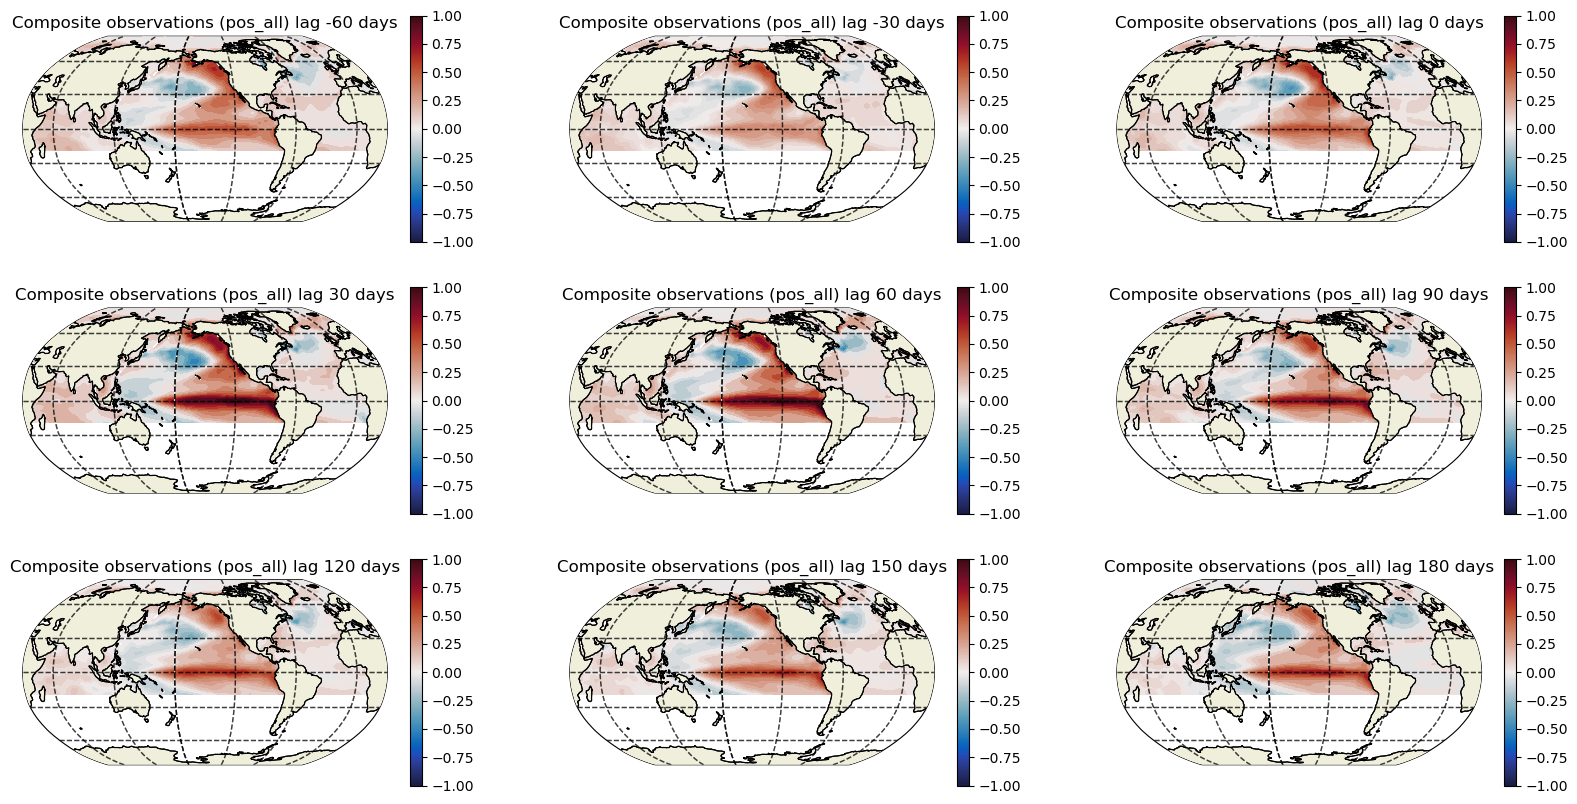

In [13]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_pos_all'], axis=0)
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (pos_all) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (positive_all)")
plt.show()

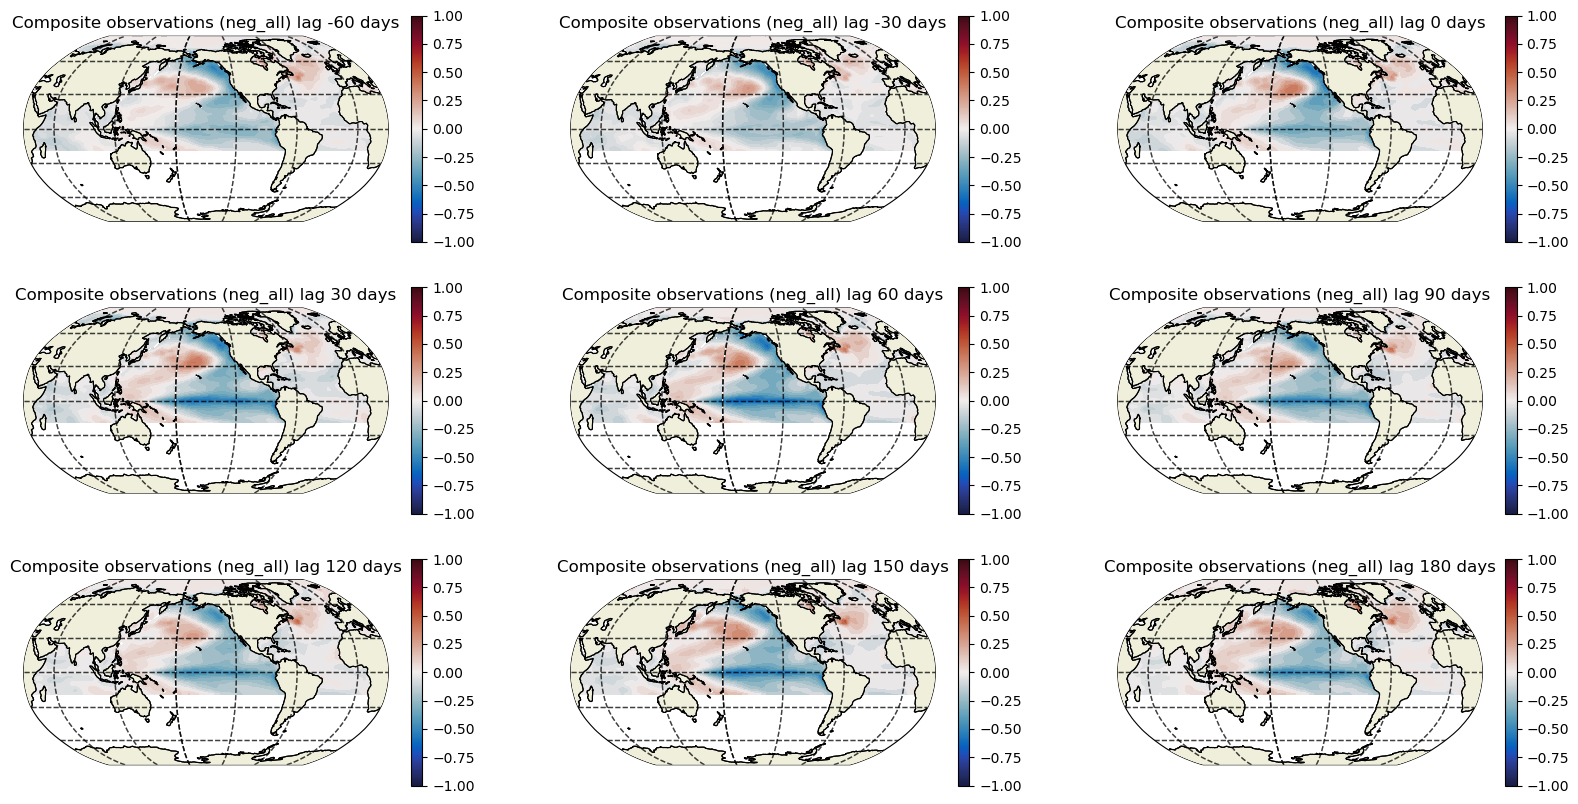

In [14]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_neg_all'], axis=0)
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (neg_all) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (negative_all)")
plt.show()

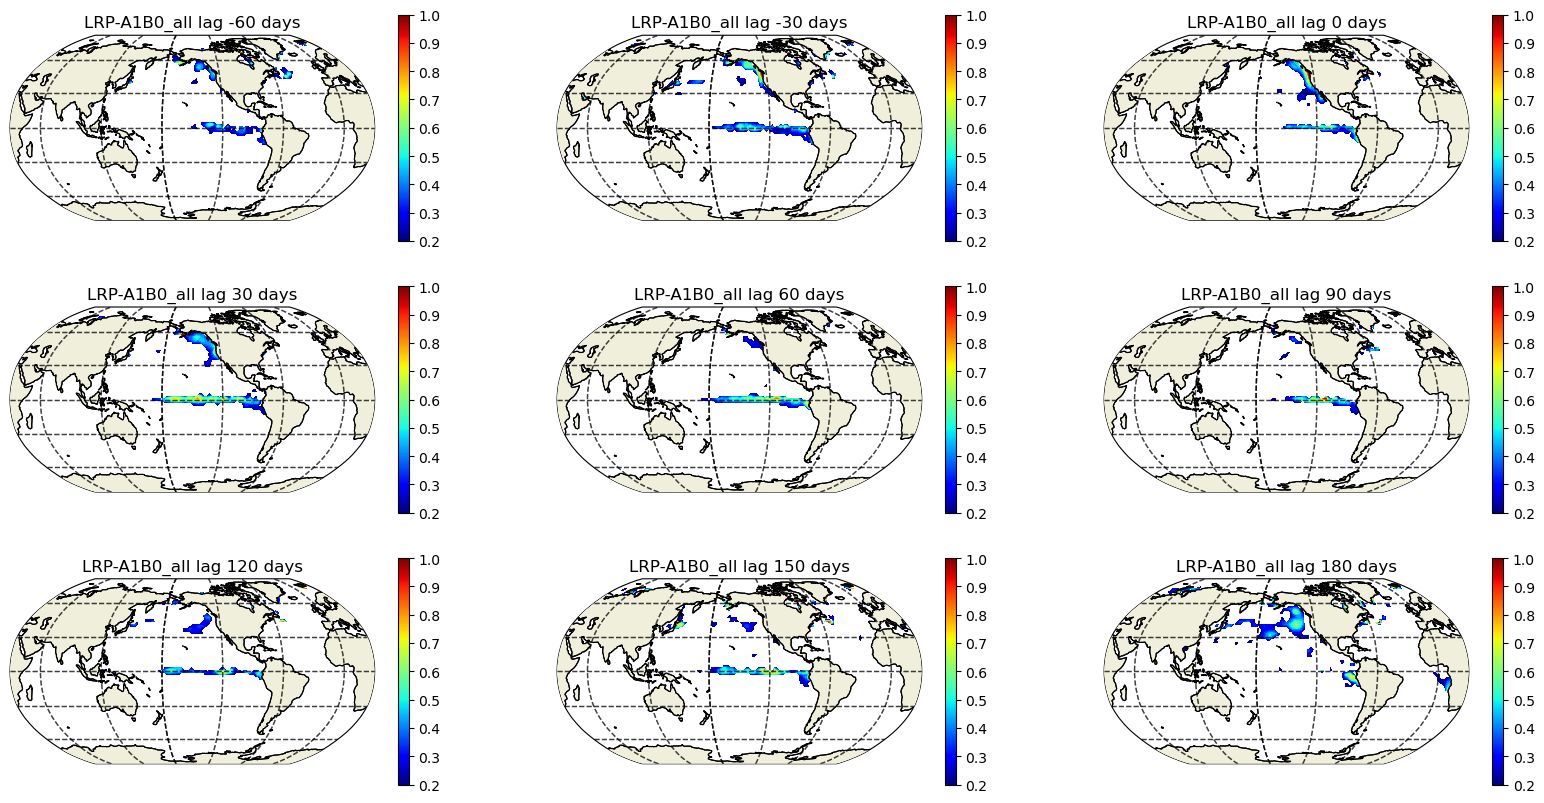

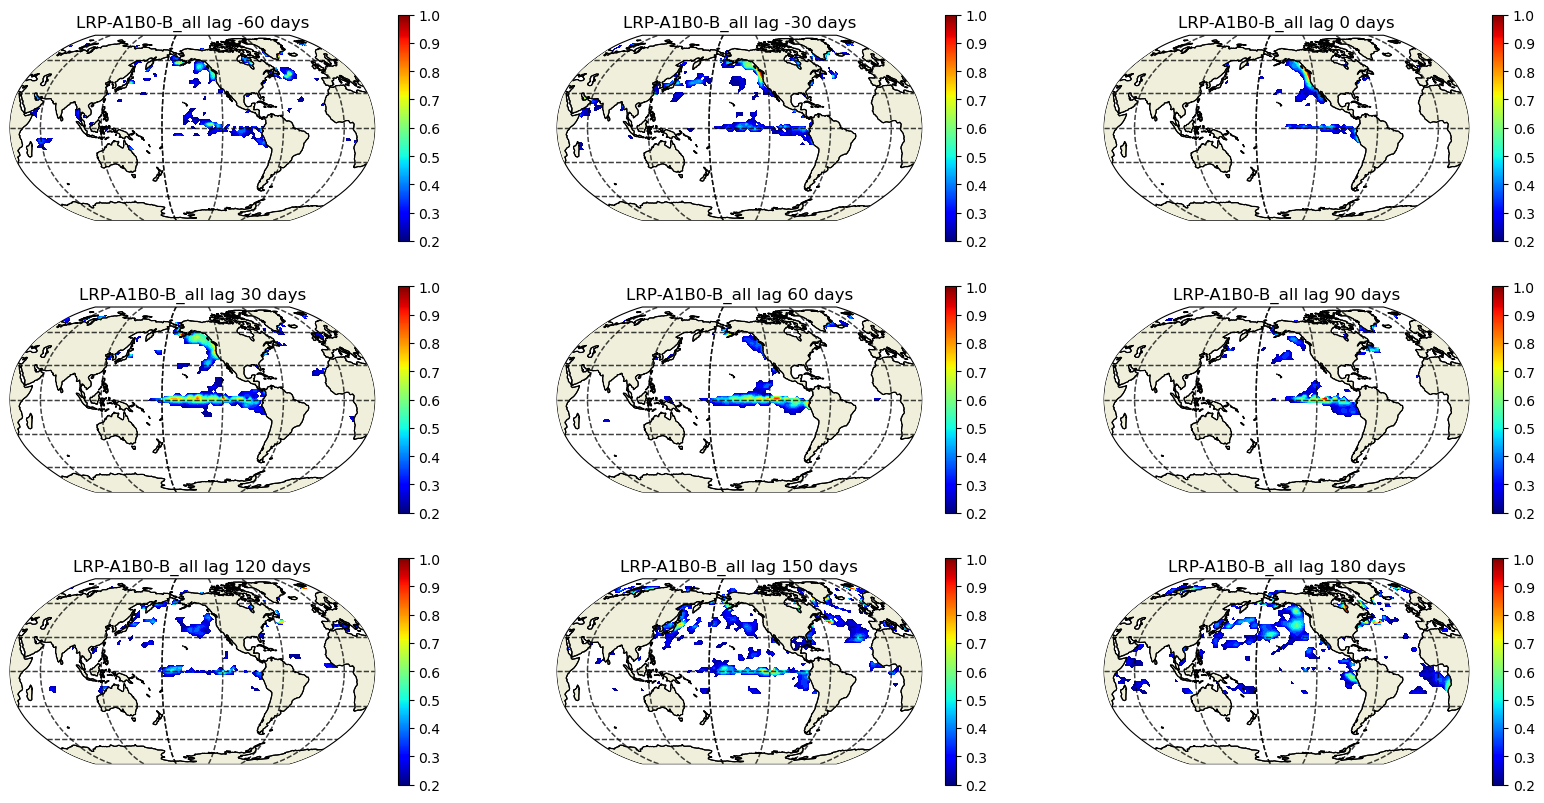

In [15]:
subplot_idx = 1
color_idx = 0

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['title']+'_pos_all'].copy()
        field[np.where(field < 0)] = 0.0
        field = np.nanmean(field, axis=0)
        field = field / np.nanmax(np.abs(field))
        field[field < 0.2] = np.nan
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar = True, 
                                      cmap = cmaps[color_idx], 
                                      cmin = color_ranges[color_idx][0], 
                                      cmax = color_ranges[color_idx][1],
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

        P[1].set_title(f"{method['title']}_all lag {lag} days")
        subplot_idx += 1

    subplot_idx = 1
    color_idx += 1
    # plt.title(f"{method['title']}_all for pos QoI' w/o neg relevances")
    plt.show()

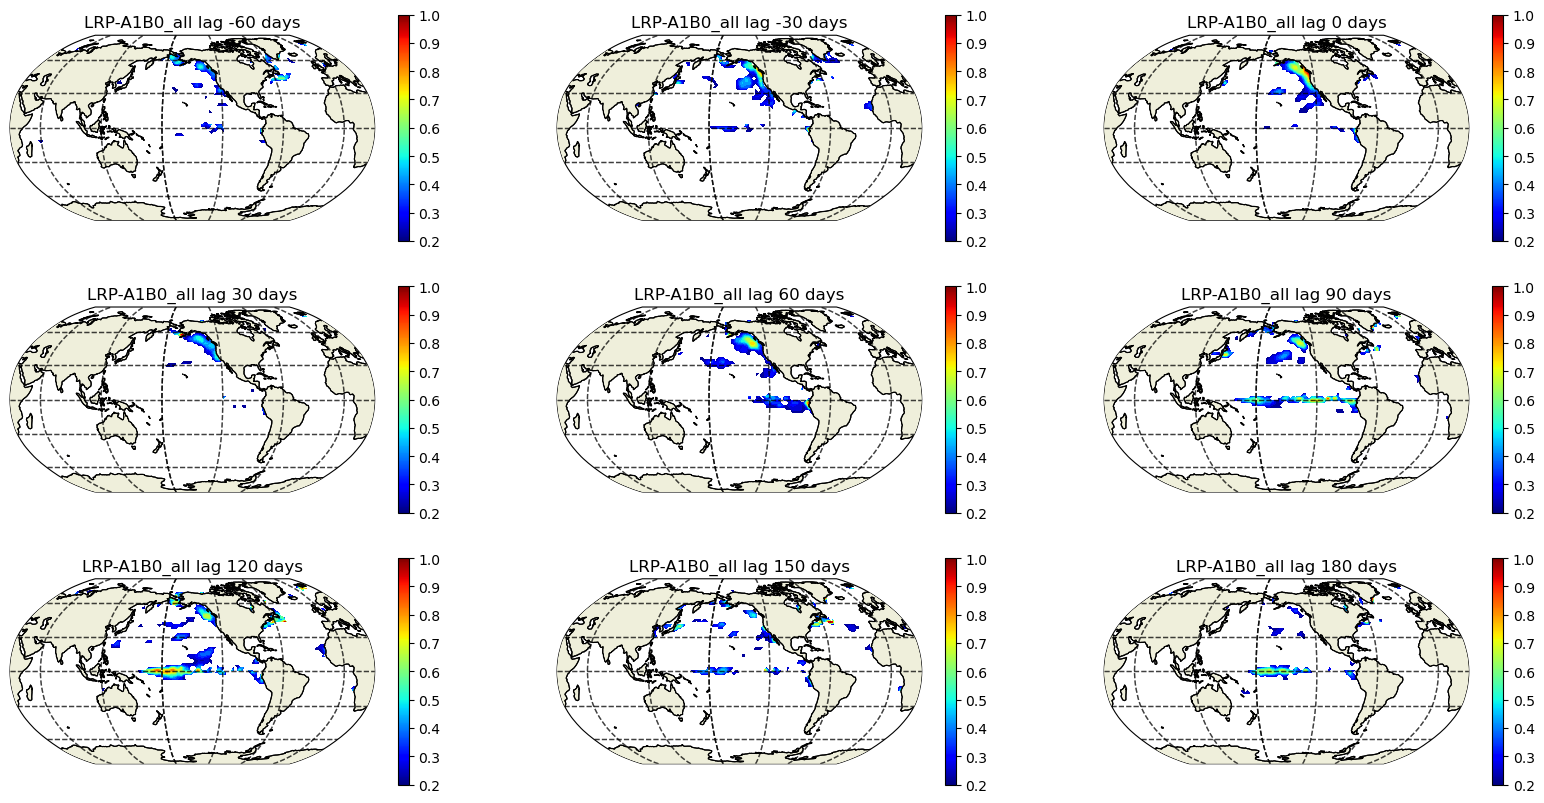

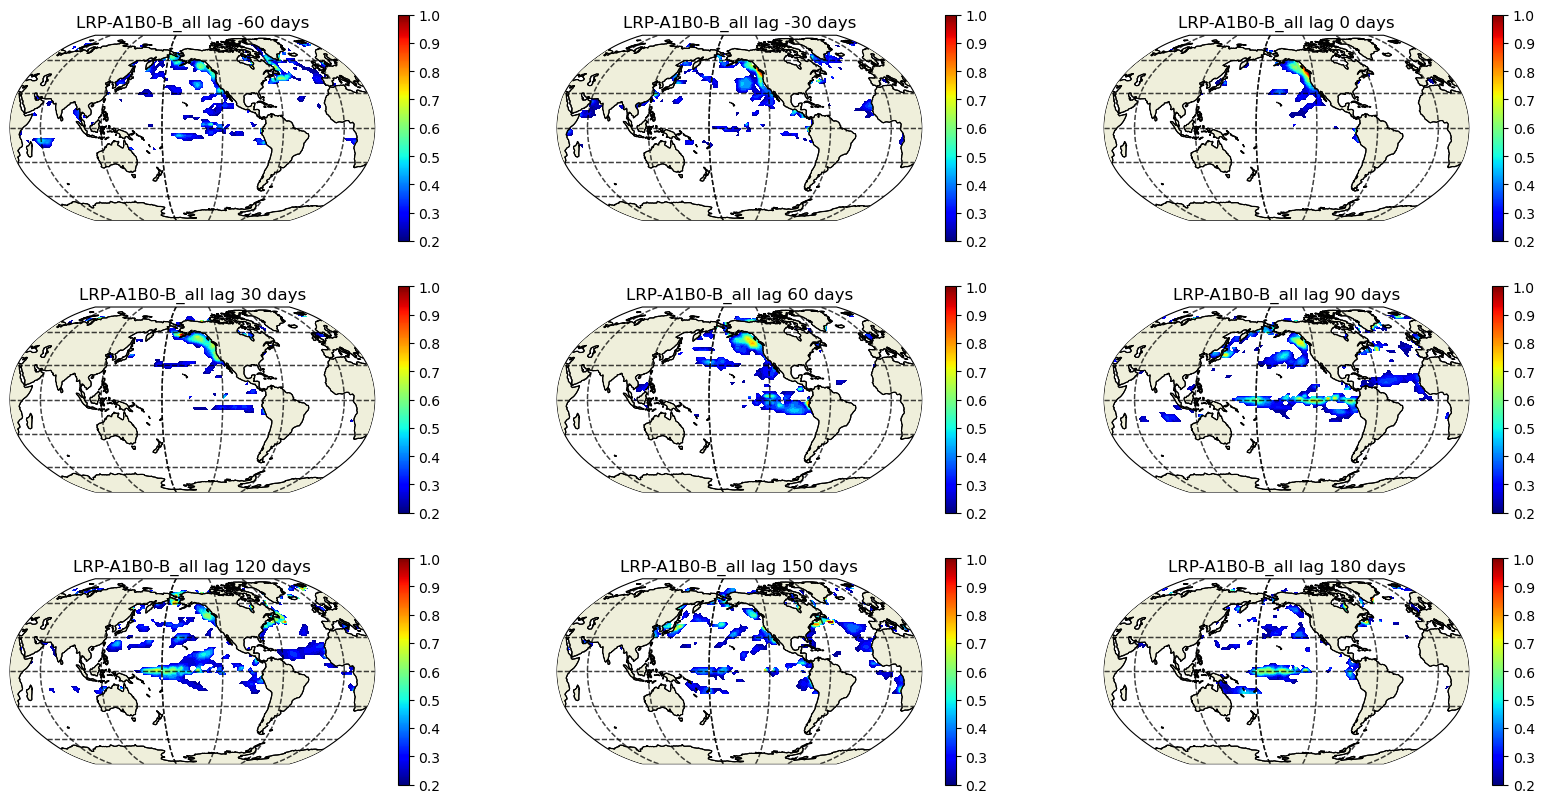

In [16]:
subplot_idx = 1
color_idx = 0

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['title']+'_neg_all'].copy()
        field[np.where(field < 0)] = 0.0
        field = np.nanmean(field, axis=0)
        field = field / np.nanmax(np.abs(field))
        field[field < 0.2] = np.nan
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar = True,
                                      cmap = cmaps[color_idx], 
                                      cmin = color_ranges[color_idx][0], 
                                      cmax = color_ranges[color_idx][1],
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])
        
        P[1].set_title(f"{method['title']}_all lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    color_idx += 1
    # plt.title(f"{method['title']}_all for neg QoI' w/o neg relevances")
    plt.show()